# Download

Mouse brain cells from Saunders et al (Drop-seq) http://dropviz.org/ --> Data

annotation R Data: annotation.BrainCellAtlas_Saunders_version_2018.04.01.rds (12K)

Hippocampus DGE  F_GRCm38.81.P60Hippocampus.raw.dge.txt.gz

Subcluster  F_GRCm38.81.P60Hippocampus.subcluster.assign.RDS

Mouse Brain cells from Zeisel et al (10X) http://mousebrain.org/downloads.html

L5_All.loom

# Preprocess

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import anndata2ri

sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.4.6 numpy==1.19.2 scipy==1.6.2 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.7.0


In [2]:
tissue = "HC"

data_path = "data_MB/" + tissue

if not os.path.exists(data_path):
    os.makedirs(data_path)

# Drop-seq

datapath_Drop = "/import/home/share/Portal-reproduce/Raw_data_Saunders"
    
dropviz_RDSname_dict = {"TH": "F_GRCm38.81.P60Thalamus.subcluster.assign.RDS",
                        "HC": "F_GRCm38.81.P60Hippocampus.subcluster.assign.RDS",
                        "CB": "F_GRCm38.81.P60Cerebellum_ALT.subcluster.assign.RDS"}
dropviz_dgename_dict = {"TH": "F_GRCm38.81.P60Thalamus.raw.dge.txt.gz",
                        "HC": "F_GRCm38.81.P60Hippocampus.raw.dge.txt.gz",
                        "CB": "F_GRCm38.81.P60Cerebellum_ALT.raw.dge.txt.gz"}

dropviz_anno = ro.r['readRDS'](datapath_Drop + "/annotation.BrainCellAtlas_Saunders_version_2018.04.01.RDS")
ro.r.assign("dropviz_anno", dropviz_anno)
ro.r.assign("tissue", tissue)
ro.r('''dropviz_anno_class <- dropviz_anno[which(dropviz_anno$tissue == tissue), c("class")]''')
dropviz_anno_class = list(ro.r("dropviz_anno_class"))
ro.r('''dropviz_anno_class_marker <- dropviz_anno[which(dropviz_anno$tissue == tissue), c("class_marker")]''')
dropviz_anno_class_marker = list(ro.r("dropviz_anno_class_marker"))
ro.r('''dropviz_anno_subcluster <- dropviz_anno[which(dropviz_anno$tissue == tissue), c("subcluster")]''')
dropviz_anno_subcluster = list(ro.r("dropviz_anno_subcluster"))

subcluster_assign = ro.r['readRDS'](datapath_Drop + "/" + dropviz_RDSname_dict[tissue])
ro.r.assign("subcluster_assign", subcluster_assign)
ro.r("subcluster_assign_name <- names(subcluster_assign)")
ro.r("subcluster_assign <- as.vector(subcluster_assign)")
subcluster_assign_name = list(ro.r("subcluster_assign_name"))
subcluster_assign = list(ro.r("subcluster_assign"))

meta_dropseq_dict = pd.DataFrame({"class": dropviz_anno_class, "marker": dropviz_anno_class_marker}, index=dropviz_anno_subcluster)
meta_dropseq_dict["subclass"] = meta_dropseq_dict["class"] + " (" + meta_dropseq_dict["marker"] + ")"

meta_dropseq = pd.DataFrame({"subcluster": subcluster_assign}, index=subcluster_assign_name)
meta_dropseq["drop_class"] = meta_dropseq_dict.loc[list(meta_dropseq["subcluster"].values)]["class"].values
meta_dropseq["drop_subclass"] = meta_dropseq_dict.loc[list(meta_dropseq["subcluster"].values)]["subclass"].values
meta_dropseq["drop_subcluster"] = (meta_dropseq["drop_class"] + "-" + meta_dropseq["subcluster"]).astype(str)

ro.r['library']("DropSeq.util")
ro.r['library']("Seurat")
ro.r['library']("SingleCellExperiment")
ro.r.assign("dge.path", datapath_Drop + "/" + dropviz_dgename_dict[tissue])
ro.r('''dge <- loadSparseDge(dge.path) ''')
ro.r("sce <- CreateSeuratObject(counts = dge)")
ro.r("sce <- as.SingleCellExperiment(sce)")

anndata2ri.activate()
adata_dropseq = ro.r('as(sce, "SingleCellExperiment")')
adata_dropseq = adata_dropseq[meta_dropseq.index]


# 10X

datapath_10X = "/import/home/share/Portal-reproduce/Raw_data_Zeisel"

tissuename_10X_dict = {"TH": "Thal", "HC": "HC", "CB": "CB"}

adata_10X = sc.read_loom(datapath_10X + "/l5_all.loom")

meta_10X = adata_10X.obs[["Tissue", "Class", "Clusters"]]
meta_10X["subclass"] = meta_10X["Class"] + "_" + meta_10X["Clusters"].astype(str)

sub_meta_10X = meta_10X[meta_10X.Tissue == tissuename_10X_dict[tissue]]
sub_adata_10X = adata_10X[meta_10X.Tissue == tissuename_10X_dict[tissue]]

sub_adata_10X = sub_adata_10X[~sub_adata_10X.obs.index.duplicated(), ~sub_adata_10X.var.index.duplicated()]
sub_meta_10X = sub_meta_10X[~sub_meta_10X.index.duplicated()]

adata_10X = sub_adata_10X

meta_dropseq["method"] = "Drop"
sub_meta_10X["method"] = "10X"
meta = pd.concat([meta_dropseq, sub_meta_10X])
meta.to_pickle(os.path.join(data_path, "meta_raw.pkl"))

adata_dropseq.obs = adata_dropseq.obs[['ident']]
adata_dropseq.write(filename=os.path.join(data_path, "adata_dropseq.h5ad"))
sub_adata_10X.write(filename=os.path.join(data_path, "adata_10X.h5ad"))

R[write to console]: Loading required package: data.table

R[write to console]: data.table 1.13.6 using 22 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: Loading required package: Matrix

R[write to console]: 
Seurat v4 will be going to CRAN in the near future;
 for more details, please visit https://satijalab.org/seurat/v4_changes


R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to 

... storing 'Reads Mapped Confidently to Exonic Regions' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Reads Mapped Confidently to Intergenic Regions' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Reads Mapped Confidently to Intronic Regions' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Reads Mapped Confidently to Transcriptome' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Region' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'SampleID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'SampleIndex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'SampleOK' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Sample_Index' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'SeqComment' as categorical
Trying to set attribute `.obs` 

# Integration using Portal

In [3]:
import portal

# Specify the GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Create a folder for saving results
result_path = "result"
if not os.path.exists(result_path):
    os.makedirs(result_path)

In [4]:
model = portal.model.Model(training_steps=2000, lambdacos=45.0)
model.preprocess(adata_dropseq, adata_10X) # perform preprocess and PCA
model.train() # train the model
model.eval() # get integrated latent representation of cells

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Finding highly variable genes...


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell


Normalizing and scaling...


    finished (0:00:00)
/home/jzhaoaz/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Dimensionality reduction via PCA...
Begining time:  Wed Dec 29 15:28:04 2021
step 0, loss_D=14.975129, loss_GAN=3.518599, loss_AE=495.444183, loss_cos=84.216759, loss_LA=375.885620
step 200, loss_D=2.976772, loss_GAN=3.805149, loss_AE=9.286812, loss_cos=6.536461, loss_LA=3.329895
step 400, loss_D=1.941404, loss_GAN=3.463280, loss_AE=5.414552, loss_cos=3.330425, loss_LA=1.662960
step 600, loss_D=2.100012, loss_GAN=3.252256, loss_AE=4.257679, loss_cos=2.864716, loss_LA=1.140062
step 800, loss_D=2.002891, loss_GAN=3.372859, loss_AE=3.328188, loss_cos=2.802228, loss_LA=0.804436
step 1000, loss_D=2.169148, loss_GAN=3.234032, loss_AE=2.923734, loss_cos=2.566845, loss_LA=0.632646
step 1200, loss_D=1.993899, loss_GAN=3.363873, loss_AE=2.878885, loss_cos=2.429204, loss_LA=0.542352
step 1400, loss_D=2.011682, loss_GAN=3.539285, loss_AE=2.794041, loss_cos=2.608109, loss_LA=0.442024
step 1600, loss_D=2.038546, loss_GAN=3.724618, loss_AE=2.573151, loss_cos=2.429665, loss_LA=0.414913
step 1800, loss

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation',
     min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1,
     verbose=True)
Construct fuzzy simplicial set
Wed Dec 29 15:28:51 2021 Finding Nearest Neighbors
Wed Dec 29 15:28:51 2021 Building RP forest with 17 trees
Wed Dec 29 15:28:53 2021 NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Wed Dec 29 15:29:24 2021 Finished Nearest Neighbor Search
Wed Dec 29 15:29:28 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


... storing 'subcluster' as categorical
... storing 'drop_class' as categorical
... storing 'drop_subclass' as categorical
... storing 'drop_subcluster' as categorical
... storing 'method' as categorical
... storing 'Tissue' as categorical
... storing 'Class' as categorical
... storing 'subclass' as categorical


Wed Dec 29 15:31:10 2021 Finished embedding


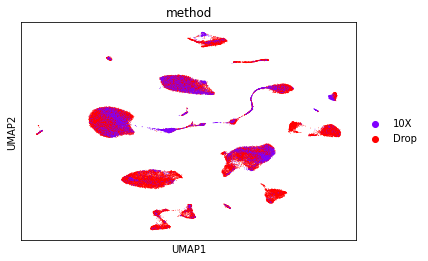

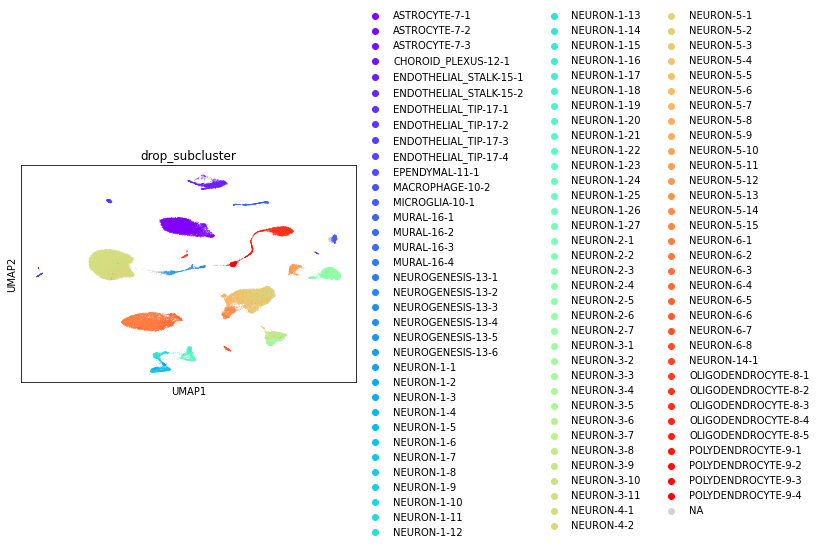

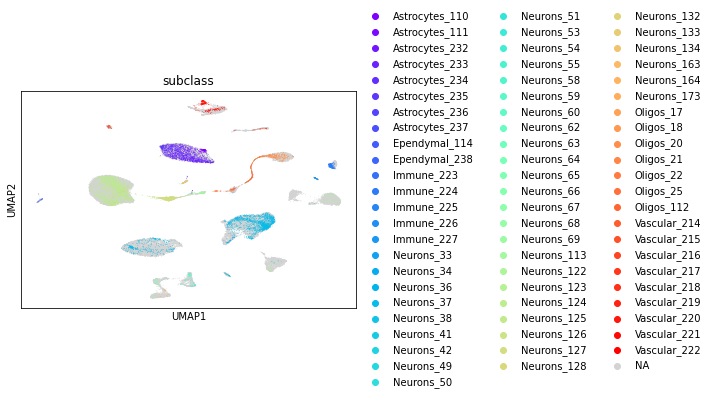

In [5]:
# The integration result can be visualized by portal.utils.plot_UMAP
portal.utils.plot_UMAP(model.latent, meta, colors=["method", "drop_subcluster", "subclass"], save=True, result_path=result_path)

# Analysis

In [6]:
# Clustering

lowdim = model.latent

cellid = meta.index.astype(str)

rpy2.robjects.numpy2ri.activate()
nr, nc = lowdim.shape
lowdim = ro.r.matrix(lowdim, nrow=nr, ncol=nc)
ro.r.assign("data", lowdim)
rpy2.robjects.numpy2ri.deactivate()

cellid = ro.StrVector(cellid)
ro.r.assign("cellid", cellid)

ro.r("set.seed(1234)")
ro.r['library']("Seurat")

ro.r("comb_normalized <- t(data)")
ro.r('''rownames(comb_normalized) <- paste("gene", 1:nrow(comb_normalized), sep = "")''')
ro.r("colnames(comb_normalized) <- as.vector(cellid)")
ro.r("comb_raw <- matrix(0, nrow = nrow(comb_normalized), ncol = ncol(comb_normalized))")
ro.r("rownames(comb_raw) <- rownames(comb_normalized)")
ro.r("colnames(comb_raw) <- colnames(comb_normalized)")
ro.r("comb <- CreateSeuratObject(comb_raw)")
ro.r('''portaldata <- Seurat::CreateDimReducObject(
            embeddings = t(comb_normalized),
            stdev = as.numeric(apply(comb_normalized, 2, stats::sd)),
            assay = "RNA",
            key = "portal")''')
ro.r('''comb[["portal"]] <- portaldata''')
ro.r('''comb <- FindNeighbors(comb, reduction = "portal", dims = 1:ncol(data), force.recalc = TRUE, verbose = FALSE)''')
ro.r('''comb <- FindClusters(comb, verbose = FALSE)''')
ro.r('''louvain <- as.vector(comb$seurat_clusters)''')

louvain = ro.r("louvain")
louvain = list(louvain)
meta["louvain"] = louvain

R[write to console]: Warning:
R[write to console]:  Keys should be one or more alphanumeric characters followed by an underscore, setting key from portal to portal_

R[write to console]: Warning:
R[write to console]:  All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to portal_



In [7]:
import anndata

adata_dropseq = anndata.read_h5ad(os.path.join(data_path, "adata_dropseq.h5ad"))
meta_dropseq = meta.loc[adata_dropseq.obs.index]
adata_dropseq = anndata.AnnData(X=adata_dropseq.X, obs=meta_dropseq, var=adata_dropseq.var).copy()

adata_10X = anndata.read_h5ad(os.path.join(data_path, "adata_10X.h5ad"))
meta_10X = meta.loc[adata_10X.obs.index]
adata_10X = anndata.AnnData(X=adata_10X.X, obs=meta_10X, var=adata_10X.var).copy()

In [8]:
sc.pp.normalize_total(adata_dropseq, target_sum=1e4)
sc.pp.log1p(adata_dropseq)
sc.pp.highly_variable_genes(adata_dropseq, flavor='seurat_v3', n_top_genes=4000)
adata_dropseq.raw = adata_dropseq

sc.pp.normalize_total(adata_10X, target_sum=1e4)
sc.pp.log1p(adata_10X)
sc.pp.highly_variable_genes(adata_10X, flavor='seurat_v3', n_top_genes=4000)
adata_10X.raw = adata_10X

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/home/jzhaoaz/.local/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [9]:
sc.tl.rank_genes_groups(adata_dropseq, groupby="louvain", groups=["4"], reference="13", method="t-test", key_added="4vs13")
sc.tl.rank_genes_groups(adata_dropseq, groupby="louvain", groups=["4"], reference="26", method="t-test", key_added="4vs26")

sc.tl.rank_genes_groups(adata_dropseq, groupby="louvain", groups=["13"], reference="4", method="t-test", key_added="13vs4")
sc.tl.rank_genes_groups(adata_dropseq, groupby="louvain", groups=["13"], reference="26", method="t-test", key_added="13vs26")

sc.tl.rank_genes_groups(adata_dropseq, groupby="louvain", groups=["26"], reference="4", method="t-test", key_added="26vs4")
sc.tl.rank_genes_groups(adata_dropseq, groupby="louvain", groups=["26"], reference="13", method="t-test", key_added="26vs13")

ranking genes
... storing 'subcluster' as categorical
... storing 'drop_class' as categorical
... storing 'drop_subclass' as categorical
... storing 'drop_subcluster' as categorical
... storing 'method' as categorical
... storing 'louvain' as categorical
    finished: added to `.uns['4vs13']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['4vs26']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
 

In [10]:
sc.tl.rank_genes_groups(adata_dropseq, groupby="louvain", groups=["4","13","26"], method="t-test", key_added="ttest")

result = adata_dropseq.uns['ttest']
groups = result['names'].dtype.names
df_genes = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(20)

ranking genes
    finished: added to `.uns['ttest']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


In [11]:
gene_4_1 = set([x[0] for x in list(adata_dropseq.uns['4vs13']['names'][:10])])
gene_4_2 = set([x[0] for x in list(adata_dropseq.uns['4vs26']['names'][:10])])
gene_4 = gene_4_1 | gene_4_2
gene_4 = set(df_genes['4_n'][:10]) & gene_4

gene_13_1 = set([x[0] for x in list(adata_dropseq.uns['13vs4']['names'][:10])])
gene_13_2 = set([x[0] for x in list(adata_dropseq.uns['13vs26']['names'][:10])])
gene_13 = gene_13_1 | gene_13_2
gene_13 = set(df_genes['13_n'][:10]) & gene_13

gene_26_1 = set([x[0] for x in list(adata_dropseq.uns['26vs4']['names'][:10])])
gene_26_2 = set([x[0] for x in list(adata_dropseq.uns['26vs13']['names'][:10])])
gene_26 = gene_26_1 | gene_26_2
gene_26 = set(df_genes['26_n'][:10]) & gene_26

genes = gene_4 | gene_13
genes = genes | gene_26

In [12]:
list(sorted(genes))

['Camk2d', 'Camk2n1', 'Igfbp5', 'Map1b', 'Nr4a2', 'Nrgn', 'Ntng1', 'Syt1']

In [13]:
adata_g4_dropseq = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "4"], list(genes)].copy()
adata_g4_dropseq.obs['group'] = 'Cluster 4 (Drop-seq)'

adata_g4_10X = adata_10X[adata_10X.obs.index[adata_10X.obs.louvain == "4"], list(genes)].copy()
adata_g4_10X.obs['group'] = 'Cluster 4 (10X)'

adata_g4 = adata_g4_dropseq.concatenate(adata_g4_10X)

... storing 'subcluster' as categorical
... storing 'drop_class' as categorical
... storing 'drop_subclass' as categorical
... storing 'drop_subcluster' as categorical
... storing 'method' as categorical
... storing 'Tissue' as categorical
... storing 'Class' as categorical
... storing 'subclass' as categorical
... storing 'louvain' as categorical
... storing 'group' as categorical


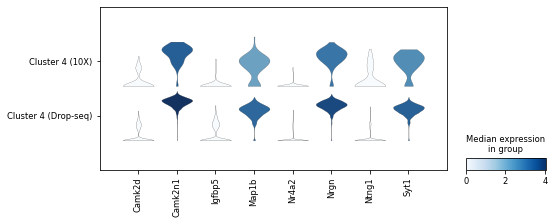

In [14]:
sc.pl.stacked_violin(adata_g4, list(sorted(genes)), 'group', figsize=(8,3), save="group4.pdf")

In [15]:
from sklearn.neighbors import KernelDensity

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

In [16]:
adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "4"], ["Camk2d"]].copy()
val_4 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_4 = np.array(adata_tmp.obs.louvain)

adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "13"], ["Camk2d"]].copy()
val_13 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_13 = np.array(adata_tmp.obs.louvain)

adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "26"], ["Camk2d"]].copy()
val_26 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_26 = np.array(adata_tmp.obs.louvain)

val = np.concatenate((val_4,val_13,val_26), axis=0)
grp = np.concatenate((grp_4,grp_13,grp_26), axis=0)

data1 = pd.DataFrame(dict(val=val, grp=grp))

In [17]:
adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "4"], ["Camk2n1"]].copy()
val_4 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_4 = np.array(adata_tmp.obs.louvain)

adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "13"], ["Camk2n1"]].copy()
val_13 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_13 = np.array(adata_tmp.obs.louvain)

adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "26"], ["Camk2n1"]].copy()
val_26 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_26 = np.array(adata_tmp.obs.louvain)

val = np.concatenate((val_4,val_13,val_26), axis=0)
grp = np.concatenate((grp_4,grp_13,grp_26), axis=0)

data2 = pd.DataFrame(dict(val=val, grp=grp))

In [18]:
adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "4"], ["Igfbp5"]].copy()
val_4 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_4 = np.array(adata_tmp.obs.louvain)

adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "13"], ["Igfbp5"]].copy()
val_13 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_13 = np.array(adata_tmp.obs.louvain)

adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "26"], ["Igfbp5"]].copy()
val_26 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_26 = np.array(adata_tmp.obs.louvain)

val = np.concatenate((val_4,val_13,val_26), axis=0)
grp = np.concatenate((grp_4,grp_13,grp_26), axis=0)

data3 = pd.DataFrame(dict(val=val, grp=grp))

In [19]:
adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "4"], ["Map1b"]].copy()
val_4 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_4 = np.array(adata_tmp.obs.louvain)

adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "13"], ["Map1b"]].copy()
val_13 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_13 = np.array(adata_tmp.obs.louvain)

adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "26"], ["Map1b"]].copy()
val_26 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_26 = np.array(adata_tmp.obs.louvain)

val = np.concatenate((val_4,val_13,val_26), axis=0)
grp = np.concatenate((grp_4,grp_13,grp_26), axis=0)

data4 = pd.DataFrame(dict(val=val, grp=grp))

In [20]:
adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "4"], ["Nr4a2"]].copy()
val_4 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_4 = np.array(adata_tmp.obs.louvain)

adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "13"], ["Nr4a2"]].copy()
val_13 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_13 = np.array(adata_tmp.obs.louvain)

adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "26"], ["Nr4a2"]].copy()
val_26 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_26 = np.array(adata_tmp.obs.louvain)

val = np.concatenate((val_4,val_13,val_26), axis=0)
grp = np.concatenate((grp_4,grp_13,grp_26), axis=0)

data5 = pd.DataFrame(dict(val=val, grp=grp))

In [21]:
adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "4"], ["Nrgn"]].copy()
val_4 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_4 = np.array(adata_tmp.obs.louvain)

adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "13"], ["Nrgn"]].copy()
val_13 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_13 = np.array(adata_tmp.obs.louvain)

adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "26"], ["Nrgn"]].copy()
val_26 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_26 = np.array(adata_tmp.obs.louvain)

val = np.concatenate((val_4,val_13,val_26), axis=0)
grp = np.concatenate((grp_4,grp_13,grp_26), axis=0)

data6 = pd.DataFrame(dict(val=val, grp=grp))

In [22]:
adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "4"], ["Ntng1"]].copy()
val_4 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_4 = np.array(adata_tmp.obs.louvain)

adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "13"], ["Ntng1"]].copy()
val_13 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_13 = np.array(adata_tmp.obs.louvain)

adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "26"], ["Ntng1"]].copy()
val_26 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_26 = np.array(adata_tmp.obs.louvain)

val = np.concatenate((val_4,val_13,val_26), axis=0)
grp = np.concatenate((grp_4,grp_13,grp_26), axis=0)

data7 = pd.DataFrame(dict(val=val, grp=grp))

In [23]:
adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "4"], ["Syt1"]].copy()
val_4 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_4 = np.array(adata_tmp.obs.louvain)

adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "13"], ["Syt1"]].copy()
val_13 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_13 = np.array(adata_tmp.obs.louvain)

adata_tmp = adata_dropseq[adata_dropseq.obs.index[adata_dropseq.obs.louvain == "26"], ["Syt1"]].copy()
val_26 = np.array(adata_tmp.X.todense()).reshape((-1))
grp_26 = np.array(adata_tmp.obs.louvain)

val = np.concatenate((val_4,val_13,val_26), axis=0)
grp = np.concatenate((grp_4,grp_13,grp_26), axis=0)

data8 = pd.DataFrame(dict(val=val, grp=grp))

In [24]:
grps = ["4","13","26"]
cors = ["#843c3a","#bc80bd","#ff7f0f"]

/home/jzhaoaz/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/jzhaoaz/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/jzhaoaz/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/jzhaoaz/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: Matplotli

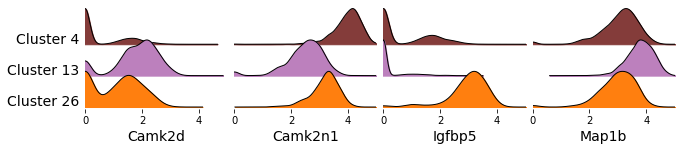

In [25]:
gs = (grid_spec.GridSpec(len(grps),4))
fig = plt.figure(figsize=(9,2))
ax_objs = []
i = 0
for g in grps:
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:1]))
    plot = (data1[data1.grp == g].val.plot.kde(ax=ax_objs[-1], color="black", lw=1.0))
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y
    ax_objs[-1].fill_between(x,y,color=cors[i])
    ax_objs[-1].set_xlim(0, 5)
    i += 1
i = 0
for g in grps:
    ax_objs.append(fig.add_subplot(gs[i:i+1, 1:2]))
    plot = (data2[data2.grp == g].val.plot.kde(ax=ax_objs[-1], color="black", lw=1.0))
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y
    ax_objs[-1].fill_between(x,y,color=cors[i])
    ax_objs[-1].set_xlim(0, 5)
    i += 1
i = 0
for g in grps:
    ax_objs.append(fig.add_subplot(gs[i:i+1, 2:3]))
    plot = (data3[data3.grp == g].val.plot.kde(ax=ax_objs[-1], color="black", lw=1.0))
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y
    ax_objs[-1].fill_between(x,y,color=cors[i])
    ax_objs[-1].set_xlim(0, 5)
    i += 1
i = 0
for g in grps:
    ax_objs.append(fig.add_subplot(gs[i:i+1, 3:4]))
    plot = (data4[data4.grp == g].val.plot.kde(ax=ax_objs[-1], color="black", lw=1.0))
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y
    ax_objs[-1].fill_between(x,y,color=cors[i])
    ax_objs[-1].set_xlim(0, 5)
    i += 1

plt.tight_layout()
gs.update(hspace= -0.2)
gs.update(wspace= 0.05)

rect = ax_objs[-1].patch
rect.set_alpha(0)

for i in range(12):
    rect = ax_objs[i].patch
    rect.set_alpha(0)
    ax_objs[i].get_yaxis().set_visible(False)
    ax_objs[i].set_yticklabels([])
    if i in [2,5,8,11]:
        ax_objs[i].tick_params(axis='both',bottom=True, top=False, left=False, right=False, labelleft=False, labelbottom=True, grid_alpha=0)
    else:
        ax_objs[i].set_xticklabels([])
        ax_objs[i].get_xaxis().set_visible(False)
    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[i].spines[s].set_visible(False)

ax_objs[0].text(-0.2, 0.02, 'Cluster 4', fontsize=14, ha="right")
ax_objs[1].text(-0.2, 0.02, 'Cluster 13', fontsize=14, ha="right")
ax_objs[2].text(-0.2, 0.02, 'Cluster 26', fontsize=14, ha="right")

ax_objs[2].set_xlabel("Camk2d", fontsize=14)
ax_objs[5].set_xlabel("Camk2n1", fontsize=14)
ax_objs[8].set_xlabel("Igfbp5", fontsize=14)
ax_objs[11].set_xlabel("Map1b", fontsize=14)

fig.savefig("DE-1.png", bbox_inches='tight', dpi=200)

/home/jzhaoaz/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/jzhaoaz/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/jzhaoaz/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/jzhaoaz/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: Matplotli

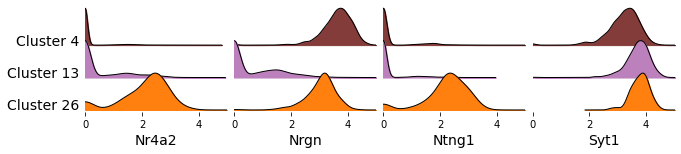

In [26]:
gs = (grid_spec.GridSpec(len(grps),4))
fig = plt.figure(figsize=(9,2))
ax_objs = []
i = 0
for g in grps:
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:1]))
    plot = (data5[data5.grp == g].val.plot.kde(ax=ax_objs[-1], color="black", lw=1.0))
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y
    ax_objs[-1].fill_between(x,y,color=cors[i])
    ax_objs[-1].set_xlim(0, 5)
    i += 1
i = 0
for g in grps:
    ax_objs.append(fig.add_subplot(gs[i:i+1, 1:2]))
    plot = (data6[data6.grp == g].val.plot.kde(ax=ax_objs[-1], color="black", lw=1.0))
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y
    ax_objs[-1].fill_between(x,y,color=cors[i])
    ax_objs[-1].set_xlim(0, 5)
    i += 1
i = 0
for g in grps:
    ax_objs.append(fig.add_subplot(gs[i:i+1, 2:3]))
    plot = (data7[data7.grp == g].val.plot.kde(ax=ax_objs[-1], color="black", lw=1.0))
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y
    ax_objs[-1].fill_between(x,y,color=cors[i])
    ax_objs[-1].set_xlim(0, 5)
    i += 1
i = 0
for g in grps:
    ax_objs.append(fig.add_subplot(gs[i:i+1, 3:4]))
    plot = (data8[data8.grp == g].val.plot.kde(ax=ax_objs[-1], color="black", lw=1.0))
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y
    ax_objs[-1].fill_between(x,y,color=cors[i])
    ax_objs[-1].set_xlim(0, 5)
    i += 1

plt.tight_layout()
gs.update(hspace= -0.2)
gs.update(wspace= 0.05)

rect = ax_objs[-1].patch
rect.set_alpha(0)

for i in range(12):
    rect = ax_objs[i].patch
    rect.set_alpha(0)
    ax_objs[i].get_yaxis().set_visible(False)
    ax_objs[i].set_yticklabels([])
    if i in [2,5,8,11]:
        ax_objs[i].tick_params(axis='both',bottom=True, top=False, left=False, right=False, labelleft=False, labelbottom=True, grid_alpha=0)
    else:
        ax_objs[i].set_xticklabels([])
        ax_objs[i].get_xaxis().set_visible(False)
    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[i].spines[s].set_visible(False)

ax_objs[0].text(-0.2, 0.02, 'Cluster 4', fontsize=14, ha="right")
ax_objs[1].text(-0.2, 0.02, 'Cluster 13', fontsize=14, ha="right")
ax_objs[2].text(-0.2, 0.02, 'Cluster 26', fontsize=14, ha="right")

ax_objs[2].set_xlabel("Nr4a2", fontsize=14)
ax_objs[5].set_xlabel("Nrgn", fontsize=14)
ax_objs[8].set_xlabel("Ntng1", fontsize=14)
ax_objs[11].set_xlabel("Syt1", fontsize=14)

fig.savefig("DE-2.png", bbox_inches='tight', dpi=200)

In [27]:
adata4 = adata_dropseq[adata_dropseq.obs.louvain.values=="4"].copy()
adata13 = adata_dropseq[adata_dropseq.obs.louvain.values=="13"].copy()
adata26 = adata_dropseq[adata_dropseq.obs.louvain.values=="26"].copy()

In [28]:
adata_new = adata4.concatenate(adata13, index_unique=None)
adata_new = adata_new.concatenate(adata26, index_unique=None)

gene_4_1 = set([x[0] for x in list(adata_dropseq.uns['4vs13']['names'][:20])])
gene_4_2 = set([x[0] for x in list(adata_dropseq.uns['4vs26']['names'][:20])])

gene_13_1 = set([x[0] for x in list(adata_dropseq.uns['13vs4']['names'][:20])])
gene_13_2 = set([x[0] for x in list(adata_dropseq.uns['13vs26']['names'][:20])])

gene_26_1 = set([x[0] for x in list(adata_dropseq.uns['26vs4']['names'][:20])])
gene_26_2 = set([x[0] for x in list(adata_dropseq.uns['26vs13']['names'][:20])])

genes = gene_4_1 | gene_4_2 | gene_13_1 | gene_13_2 | gene_26_1 | gene_26_2
adata_new = adata_new[:, list(genes)]

In [29]:
cov = np.corrcoef(adata_new.X.A)

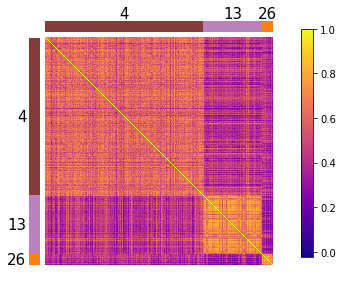

In [30]:
f = plt.figure(figsize=(6,6))
plt.imshow(cov, cmap='plasma', interpolation='nearest')
plt.axis("off")
plt.colorbar(shrink=0.7)
plt.bar(-200, len(cov), width=200, color=cors[2])
plt.bar(-200, adata4.shape[0] + adata13.shape[0], width=200, color=cors[1])
plt.bar(-200, adata4.shape[0], width=200, color=cors[0])

plt.barh(-200, len(cov), height=200, color=cors[2])
plt.barh(-200, adata4.shape[0] + adata13.shape[0], height=200, color=cors[1])
plt.barh(-200, adata4.shape[0], height=200, color=cors[0])

plt.annotate('4', fontsize=15, ha='right', va='center', xy=(-350, adata4.shape[0]/2))
plt.annotate('4', fontsize=15, ha='center', xy=(adata4.shape[0]/2, -350))

plt.annotate('13', fontsize=15, ha='right', va='center', xy=(-350, adata4.shape[0] + adata13.shape[0]/2))
plt.annotate('13', fontsize=15, ha='center', xy=(adata4.shape[0] + adata13.shape[0]/2, -350))

plt.annotate('26', fontsize=15, ha='right', va='center', xy=(-350, adata4.shape[0] + adata13.shape[0] + adata26.shape[0]/2))
plt.annotate('26', fontsize=15, ha='center', xy=(adata4.shape[0] + adata13.shape[0] + adata26.shape[0]/2, -350))
# plt.ylabel('Louvain clusters')
f.savefig("HC_correlation.png", bbox_inches='tight', dpi=100)
